In [ ]:
from zipfile import ZipFile

# Extract the ZIP file
with ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("fashion_mnist_png")

###  Setup and Imports

Let’s start by importing our libraries and confirming the dataset structure, then move on to deeper exploration like class distributions, image stats, and sample visualizations.

In [ ]:
# Let's begin by importing the libraries we will use for data exploration.
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# We'll use this for the image generator again
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Directory Structure and Image Counts

Now, let's define our paths and check how many images we have in each class for both train and test sets.


In [ ]:
# Now, let's define our paths and check how many images we have in each class for both train and test sets.

root_dir = "fashion_mnist_png"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")

# Function to count images per class
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[int(class_name)] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Print image counts per class
print("Training Set Image Counts:")
for label, count in sorted(train_counts.items()):
    print(f"Class {label}: {count} images")

print("\nTest Set Image Counts:")
for label, count in sorted(test_counts.items()):
    print(f"Class {label}: {count} images")


Training Set Image Counts:
Class 0: 6000 images
Class 1: 6000 images
Class 2: 6000 images
Class 3: 6000 images
Class 4: 6000 images
Class 5: 6000 images
Class 6: 6000 images
Class 7: 6000 images
Class 8: 6000 images
Class 9: 6000 images

Test Set Image Counts:
Class 0: 1000 images
Class 1: 1000 images
Class 2: 1000 images
Class 3: 1000 images
Class 4: 1000 images
Class 5: 1000 images
Class 6: 1000 images
Class 7: 1000 images
Class 8: 1000 images
Class 9: 1000 images


Looking at the image counts, we observe a balanced distribution across all categories. Each class has exactly 6,000 images in the training set and 1,000 in the test set.This gives us confidence that our model will learn each class equally without the need for resampling or class weighting.

### Map Labels to Class Names

Here we define class labels to make visualizations more human-friendly

In [ ]:
class_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


### Image Size and Pixel Intensity Check

Let's now pick a few images at random and check their size, mode, and pixel value range


In [ ]:
def inspect_random_images(directory, num_samples=5):
    print("Inspecting a few sample images from:", directory)
    sample_stats = []
    for class_folder in random.sample(os.listdir(directory), 3):
        folder_path = os.path.join(directory, class_folder)
        for img_file in random.sample(os.listdir(folder_path), num_samples):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            img_array = np.array(img)
            sample_stats.append({
                "Class": class_labels[int(class_folder)],
                "Size": img.size,
                "Mode": img.mode,
                "Min": img_array.min(),
                "Max": img_array.max(),
                "Mean": round(img_array.mean(), 2),
                "Std": round(img_array.std(), 2)
            })
    return sample_stats

# Let's run this on the training set
stats = inspect_random_images(train_dir)
import pandas as pd
pd.DataFrame(stats)


Inspecting a few sample images from: fashion_mnist_png/train


,Class,Size,Mode,Min,Max,Mean,Std
0,T-shirt/top,"(28, 28)",L,0,255,72.32,95.19
1,T-shirt/top,"(28, 28)",L,0,255,70.34,73.94
2,T-shirt/top,"(28, 28)",L,0,255,50.17,61.85
3,T-shirt/top,"(28, 28)",L,0,255,98.71,95.52
4,T-shirt/top,"(28, 28)",L,0,255,98.43,92.14
5,Sandal,"(28, 28)",L,0,255,27.18,59.61
6,Sandal,"(28, 28)",L,0,255,20.10,49.02
7,Sandal,"(28, 28)",L,0,255,77.22,99.55
8,Sandal,"(28, 28)",L,0,255,39.11,72.15
9,Sandal,"(28, 28)",L,0,255,17.79,48.85


The sample stats confirm our images are uniformly 28x28 grayscale with pixel values in the full range of 0–255. We notice that sandals tend to have lower mean brightness than T-shirts or dresses, which reflects their visual characteristics.

### Display Grid of Sample Images per Class

Now let's show a grid of 2 images per class for a visual overview

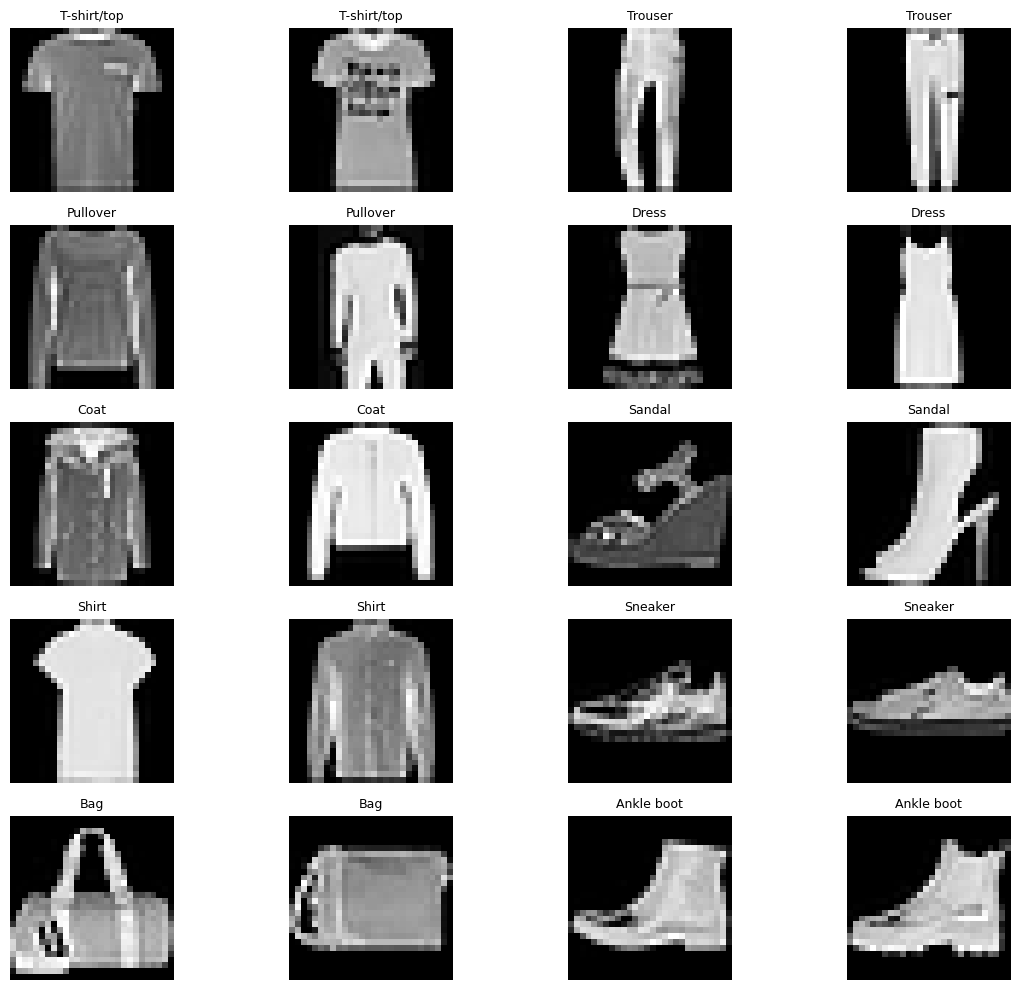

In [ ]:
rows, cols = 5, 4
plt.figure(figsize=(12, 10))
i = 1

for label_id, label_name in class_labels.items():
    class_path = os.path.join(train_dir, str(label_id))
    img_files = os.listdir(class_path)
    for img_name in random.sample(img_files, 2):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap="gray")
        plt.title(label_name, fontsize=9)
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()


### Image Pixel Intensity Histogram

Let's also check the overall pixel distribution in a sample batch

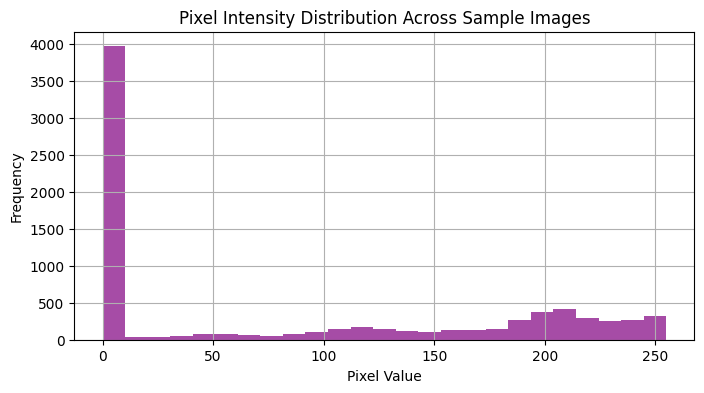

In [ ]:
# Let's also check the overall pixel distribution in a sample batch
sample_images = []
for label_id in class_labels.keys():
    class_path = os.path.join(train_dir, str(label_id))
    sample_file = random.choice(os.listdir(class_path))
    img = Image.open(os.path.join(class_path, sample_file))
    sample_images.append(np.array(img))

flattened_pixels = np.concatenate([img.flatten() for img in sample_images])
plt.figure(figsize=(8, 4))
plt.hist(flattened_pixels, bins=25, color='purple', alpha=0.7)
plt.title("Pixel Intensity Distribution Across Sample Images")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


The histogram shows that a large number of pixels are black or very dark. However, we also see a wide range of brightness levels across the images. This variety is good because it helps the model recognize different textures and edges.

###Per-Class Average Image (Optional Insight)

Let’s now take it a step further and compute the average image for each class. This will help us visualize the general shape or outline of the clothing items in each category.

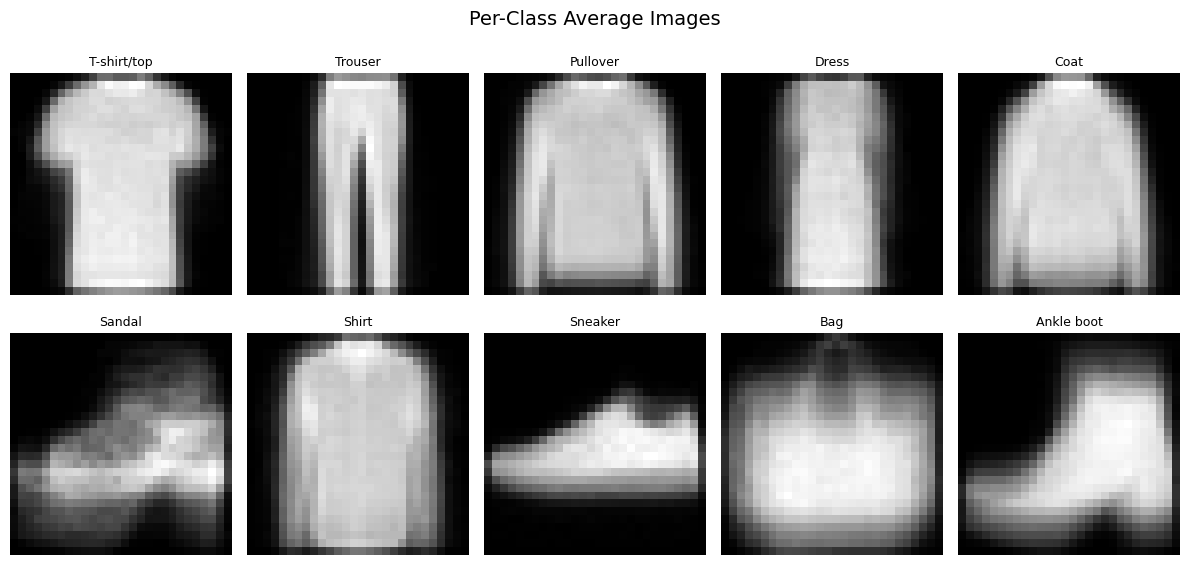

In [ ]:
avg_images = {}

plt.figure(figsize=(12, 6))
for class_id, class_name in class_labels.items():
    class_path = os.path.join(train_dir, str(class_id))
    img_arrays = []

    # Use a subset to speed up
    sample_imgs = random.sample(os.listdir(class_path), 100)

    for img_name in sample_imgs:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('L')  # Ensure grayscale
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_arrays.append(img_array)

    avg_image = np.mean(img_arrays, axis=0)
    avg_images[class_id] = avg_image

    plt.subplot(2, 5, class_id + 1)
    plt.imshow(avg_image, cmap='gray')
    plt.title(class_name, fontsize=9)
    plt.axis('off')

plt.suptitle("Per-Class Average Images", fontsize=14)
plt.tight_layout()
plt.show()


From the average images above, we can clearly see the typical outlines of each clothing category. The T-shirt/top, Pullover, and Shirt classes show a rounded upper-body shape with sleeves. Trouser appears long and narrow, while Dress and Coat show full-body coverage with softer edges. Sneaker and Ankle boot display distinct footwear profiles, with Ankle boot having a taller silhouette. Sandal looks flatter and more dispersed, which matches its open design. The Bag class has a bulky, central structure with handles slightly visible. These average overlays help us understand the common visual features that the model is likely to learn during training.

###Data Augmentation Preview

Now let’s preview a few augmented versions of a training image using ImageDataGenerator. This helps us understand how we can increase dataset variety and improve generalization.

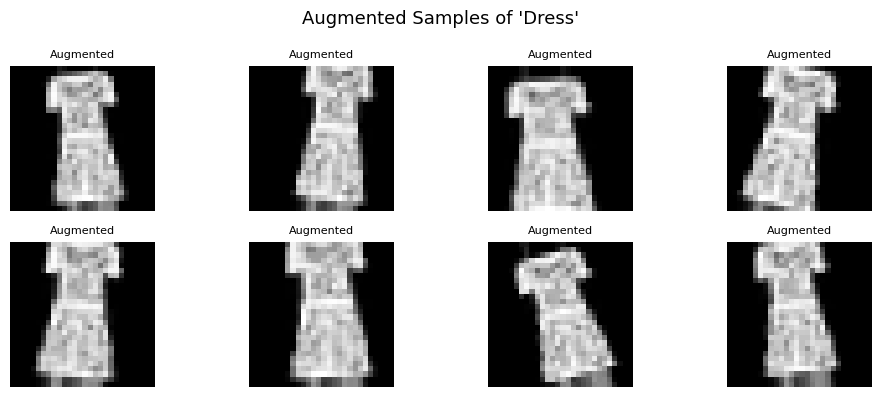

In [ ]:
# Let's define a simple augmentation pipeline and visualize some results
aug_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

# Select one image from class "Dress" (3)
sample_class = "3"
sample_path = os.path.join(train_dir, sample_class)
sample_img = Image.open(os.path.join(sample_path, random.choice(os.listdir(sample_path))))
img_array = np.array(sample_img).reshape((1, 28, 28, 1)) / 255.0  # Reshape for generator

# Generate and plot augmented samples
plt.figure(figsize=(10, 4))
aug_iter = aug_datagen.flow(img_array, batch_size=1)
for i in range(8):
    batch = next(aug_iter)[0].reshape(28, 28)
    plt.subplot(2, 4, i + 1)
    plt.imshow(batch, cmap='gray')
    plt.title("Augmented", fontsize=8)
    plt.axis('off')

plt.suptitle("Augmented Samples of 'Dress'", fontsize=13)
plt.tight_layout()
plt.show()


In the image above, we applied basic augmentation techniques—including slight rotation, zooming, horizontal and vertical shifting, and shearing—to a sample image from the Dress class. As we can see, all the augmented images maintain the core structure of a dress, but with small changes in position and perspective. These variations mimic real-world scenarios such as changes in pose or camera angle. By training the model on such augmented examples, we help it learn more flexible and generalizable features, which improves its performance on unseen images.